# Long Term Credit Rating Projection 

## Import of all the packages needed

In [1]:
import pandas as pd
import numpy as np
#If installation is neeeded to run code, remove the # at the front of the following lines:
#!pip install tensorflow
#!pip install Keras
#!pip install import-ipynb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.imputation.mice import MICE, MICEData
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.constraints import maxnorm
from matplotlib import pyplot
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# import fancyimpute
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
import time
import datetime
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import itertools
#import all the functions we wrote ourselves
import import_ipynb
import Functions as functions




Using TensorFlow backend.


importing Jupyter notebook from Functions.ipynb
Note: you may need to restart the kernel to use updated packages.


## Importing and Preprocessing Data

Get the 3 provided csv and merge them into one Pandas-Dataframe.

In [2]:
#Add Keyfigures 
arr1=pd.read_csv("Keyfigures.csv")
#Add Ratings
arr2=pd.read_csv("Ratings.csv")
#Add S&P500 Company List
arr3=pd.read_csv("SP500_CompanyList.csv")
#Combine Keyfigures and S&P500 Company List
rest=functions.combine_keyfigures_and_Companies(arr1,arr3)
#Add Ratings to the mapping
mapping=functions.combine_Ratings_and_Rest(rest,arr2)

Save the joint Dataframe for further use in a csv:

In [3]:
#mapping.to_csv(r'C:\Users\Sandro\OneDrive\Dokumente\Universität Zürich\Aufbaustufe\2020 FS\Introduction to Machine Learning\Group Project\Data\Clean Mapping.csv')

In [4]:
#df = pd.read_csv(r'C:\Users\Sandro\OneDrive\Dokumente\Universität Zürich\Aufbaustufe\2020 FS\Introduction to Machine Learning\Group Project\Data\Clean Mapping.csv', sep=';',
                #parse_dates=['adate', 'qdate', 'public_date', 'datadate'])
df = mapping
df=df.rename(columns={'public_date_x':'public_date'})
df=df.rename(columns={'TICKER_x':'TICKER'})
df=df.rename(columns={'TICKER_y':'tic'})
df= df.drop(['public_date_y'],1)

Deleting all the rows where splticrm has NA values.

In [5]:
df = df[df['splticrm'].notna()]

In [6]:
df = df[df['splticrm'] != 'D']
df = df[df['splticrm'] != 'CCC']
print(df.head())

   permno       adate     qdate public_date   CAPEI     bm     evm  \
0   10104  20090531.0  20091130  2010-01-31  26.386  0.252  10.110   
1   10104  20090531.0  20091130  2010-02-28  28.226  0.252  10.110   
2   10104  20090531.0  20091130  2010-03-31  29.464  0.252  10.110   
3   10104  20090531.0  20100228  2010-04-30  28.783  0.233  10.983   
4   10104  20090531.0  20100228  2010-05-31  25.096  0.233  10.983   

   pe_op_basic  pe_op_dil  pe_exi  ...     CUSIP  NWPERM    PRC  \
0       19.217     19.378  20.052  ...  68389X10       0  44.06   
1       20.542     20.714  21.435  ...  68389X10       0  44.06   
2       21.425     21.605  22.357  ...  68389X10       0  44.06   
3       21.378     21.556  23.096  ...  68389X10       0  44.06   
4       18.653     18.808  20.152  ...  68389X10       0  44.06   

              key    gvkey  splticrm    datadate         conm   tic      cusip  
0  2010-01-31ORCL  12142.0         A  20100131.0  ORACLE CORP  ORCL  68389X105  
1  2010-02-28O

In [7]:
Y = pd.factorize(df["splticrm"])[0]
print(np.bincount(Y))
print(pd.factorize(df["splticrm"])[1])
Y = pd.DataFrame(Y, columns=["Rating as Factor"])
print(Y)

[3656 1943  990  296 5455 3209  489 3882 4682  199   50  143  382 1069
 1648 1096  220]
Index(['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+',
       'CCC+', 'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
      dtype='object')
       Rating as Factor
0                     0
1                     0
2                     0
3                     0
4                     0
...                 ...
29404                 8
29405                 8
29406                 8
29407                 8
29408                 8

[29409 rows x 1 columns]


After taking a first look at the data we see that for ratings D and CCC we only have 4, respectively 2 observations. Therefore we delete these values due to the very low number of observations.

### Handling missing data
We decided to drop columns which contain more than 10'000 (corresponds to roughly 30%)  NA values or zero values.

In [8]:
NAs = df.isnull().sum() > 10000
Zeros =  (df == 0).sum() > 10000
delNAs = df.columns[NAs] #drops PEG_trailing
delZeros= df.columns[Zeros] #drops rd_sale, adv_sale, staff_sale
df = df.drop(delNAs, axis=1)
df = df.drop(delZeros, axis=1)
df.to_csv('Clean Mapping.csv')

Create a column of Ratings which are lagging by 1 Month and merge it with the dataframe

In [9]:
nest_list=functions.create_lagging_Ratings_1M('Clean Mapping.csv')
dframe=pd.DataFrame(nest_list,columns=['key','Lagging-Rating_1M'])
#Replace the Nonetype from python with NaN from pandas
dframe.fillna(value=pd.np.nan, inplace=True)
#Now merge the new Dataframe to our main-df
df = df.merge(dframe, how='left', on=['key'])
df.head()

D:\Programme\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


,permno,adate,qdate,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,...,CUSIP,PRC,key,gvkey,splticrm,datadate,conm,tic,cusip,Lagging-Rating_1M
0,10104,20090531.0,20091130,2010-01-31,26.386,0.252,10.110,19.217,19.378,20.052,...,68389X10,44.06,2010-01-31ORCL,12142.0,A,20100131.0,ORACLE CORP,ORCL,68389X105,A
1,10104,20090531.0,20091130,2010-02-28,28.226,0.252,10.110,20.542,20.714,21.435,...,68389X10,44.06,2010-02-28ORCL,12142.0,A,20100228.0,ORACLE CORP,ORCL,68389X105,A
2,10104,20090531.0,20091130,2010-03-31,29.464,0.252,10.110,21.425,21.605,22.357,...,68389X10,44.06,2010-03-31ORCL,12142.0,A,20100331.0,ORACLE CORP,ORCL,68389X105,A
3,10104,20090531.0,20100228,2010-04-30,28.783,0.233,10.983,21.378,21.556,23.096,...,68389X10,44.06,2010-04-30ORCL,12142.0,A,20100430.0,ORACLE CORP,ORCL,68389X105,A
4,10104,20090531.0,20100228,2010-05-31,25.096,0.233,10.983,18.653,18.808,20.152,...,68389X10,44.06,2010-05-31ORCL,12142.0,A,20100531.0,ORACLE CORP,ORCL,68389X105,A


Assign to X all the columns but splticrm. Then we drop some columns which will not be relevant for the algorithms.

In [10]:
X = df.loc[:, df.columns != "splticrm"]
X = X.drop(["permno", "CUSIP", "NCUSIP", "adate", "qdate", "public_date", "TICKER"], axis=1)
X = X.drop(["COMNAM", "PERMCO", "gvkey", "datadate", "tic", "cusip", "conm", "PRC"], axis=1)
X.head()

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,sale_equity,sale_nwc,accrual,ptb,DIVYIELD,PEG_1yrforward,PEG_ltgforward,date,key,Lagging-Rating_1M
0,26.386,0.252,10.110,19.217,19.378,20.052,20.052,4.976,13.353,0.129,...,0.912,1.894,0.058,4.145,.867%,2.221,1.554,29/06/2018,2010-01-31ORCL,A
1,28.226,0.252,10.110,20.542,20.714,21.435,21.435,5.323,14.285,0.129,...,0.912,1.894,0.058,4.434,.811%,2.058,1.520,29/06/2018,2010-02-28ORCL,A
2,29.464,0.252,10.110,21.425,21.605,22.357,22.357,5.556,14.911,0.129,...,0.912,1.894,0.058,4.628,.778%,2.146,1.586,29/06/2018,2010-03-31ORCL,A
3,28.783,0.233,10.983,21.378,21.556,23.096,23.096,5.381,15.909,0.177,...,0.902,1.891,0.049,4.515,.773%,1.848,1.642,29/06/2018,2010-04-30ORCL,A
4,25.096,0.233,10.983,18.653,18.808,20.152,20.152,4.692,13.871,0.177,...,0.902,1.891,0.049,3.937,.886%,1.612,1.432,29/06/2018,2010-05-31ORCL,A


### Handling missing data
We decided to drop columns which contain more than 10'000 (corresponds to roughly 30%)  NA values or zero values.

Now we split the data into a train and a test set. The test set consists of 20% of the whole dataset.

In [11]:
#now do the train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=Y)

In [12]:
X_train.head(1)


,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,sale_equity,sale_nwc,accrual,ptb,DIVYIELD,PEG_1yrforward,PEG_ltgforward,date,key,Lagging-Rating_1M
6595,36.03,0.235,12.83,11.986,12.131,13.943,6.876,1.884,13.644,0.334,...,2.794,4.008,0.062,4.444,1.33%,0.978,1.281,29/06/2018,2014-05-31PPG,A-


In [13]:
X_train.isna().sum()

CAPEI                  47
bm                    529
evm                    76
pe_op_basic           274
pe_op_dil             278
                     ... 
PEG_1yrforward        799
PEG_ltgforward       1286
date                    0
key                     0
Lagging-Rating_1M     313
Length: 70, dtype: int64

We see that there are still missing values that have to be imputed. We do this in the next section.

#### Iterative Imputer
The iterative imputer imputes missing values by by modeling each feature containing missing values as a function of other features and is applied separately to the train and test set.

In [14]:
num_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 
            'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
            'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
            'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
            'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
            'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
            'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
            'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'accrual', 'ptb',
            'DIVYIELD', 'PEG_1yrforward', 'PEG_ltgforward']

# Copy df to df_mice_imputed
X_train_imputed = X_train[num_cols].copy(deep=True)

#Remove "%" from the DIVYIELD-Col
X_train_imputed['DIVYIELD'] = X_train_imputed['DIVYIELD'].str.rstrip('%').astype('float') / 100.0

# Initialize IterativeImputer
mice_imputer = IterativeImputer(random_state=0, max_iter=20)

# Impute using fit_tranform on training set
X_train_imputed.iloc[:, :] = mice_imputer.fit_transform(X_train_imputed[num_cols])

# Copy df to df_mice_imputed
X_test_imputed = X_test[num_cols].copy(deep=True)
X_test_imputed['DIVYIELD'] = X_test_imputed['DIVYIELD'].str.rstrip('%').astype('float') / 100.0

# Impute using tranformation of training set on test set
X_test_imputed.iloc[:, :] = mice_imputer.transform(X_test_imputed[num_cols])

D:\Programme\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


#### Create train and test data with lagging ratings

In [15]:
#Save lagging ratings
lag_rating_train = X_train["Lagging-Rating_1M"]
lag_rating_test = X_test["Lagging-Rating_1M"]

#Merge imputed data with lagging ratings
X_train_imputed_lag = X_train_imputed.copy()
X_test_imputed_lag = X_test_imputed.copy()

X_train_imputed_lag["Lagging-Rating_1M"] = lag_rating_train
X_test_imputed_lag["Lagging-Rating_1M"] = lag_rating_test

#Define indetificator for train/test set in order to combine, modify and separate them again
X_train_imputed_lag["train"] = 1
X_test_imputed_lag["train"] = 0

#Combine both to factorize lagged ratings together
combined = pd.concat([X_train_imputed_lag, X_test_imputed_lag])

#Drop rows with NA in lagged rating
combined = combined[combined["Lagging-Rating_1M"].notna()]
print(pd.factorize(combined["Lagging-Rating_1M"])[1])
combined["Lagging-Rating_1M"] = pd.factorize(combined["Lagging-Rating_1M"])[0]
print(np.bincount(combined["Lagging-Rating_1M"]))

#Separate train and test set
X_train_imputed_lag = combined[combined["train"] == 1]
X_test_imputed_lag = combined[combined["train"] == 0]
X_train_imputed_lag.drop(["train"], axis=1, inplace=True)
X_test_imputed_lag.drop(["train"], axis=1, inplace=True)

#Get the lagging ratings Dataframes Y for train and test set
y_train_lag = X_train_imputed_lag["Lagging-Rating_1M"]
y_test_lag = X_test_imputed_lag["Lagging-Rating_1M"]

y_train_lag = pd.DataFrame(y_train_lag)
y_test_lag = pd.DataFrame(y_test_lag)

#Drop Lagging Raating out of imputed feature matrix
X_train_imputed_lag.drop(["Lagging-Rating_1M"], axis=1, inplace=True)
X_test_imputed_lag.drop(["Lagging-Rating_1M"], axis=1, inplace=True)

y_train_lag.head(5)

Index(['A-', 'BBB', 'BBB+', 'B+', 'A', 'A+', 'AA-', 'BB', 'BB+', 'BBB-', 'AA+',
       'B', 'BB-', 'AA', 'AAA', 'CCC+', 'B-'],
      dtype='object')
[3847 5388 4630  375 3610 1921  975 1077 1625 3153  196  214 1049  482
  292   48  136]


D:\Programme\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Lagging-Rating_1M
6595,0
26131,0
8093,0
23847,1
25714,0


### Feature Selection
#### For ordinary ratings
To find out which variables are most important we run the 'features_selection' function and select all variables which explain more than 1.5%.

 1) intcov_ratio 0.0277
 2) debt_assets 0.0237
 3) gpm     0.0210
 4) intcov  0.0206
 5) int_totdebt 0.0202
 6) dpr     0.0198
 7) rect_turn 0.0197
 8) lt_debt 0.0196
 9) debt_ebitda 0.0195
10) cash_conversion 0.0195
11) inv_turn 0.0194
12) CAPEI   0.0193
13) cfm     0.0191
14) lt_ppent 0.0183
15) invt_act 0.0183
16) debt_capital 0.0182
17) DIVYIELD 0.0179
18) sale_equity 0.0177
19) capital_ratio 0.0174
20) rect_act 0.0172
21) equity_invcap 0.0172
22) GProf   0.0166
23) ptpm    0.0166
24) at_turn 0.0163
25) npm     0.0161
26) roce    0.0161
27) debt_invcap 0.0160
28) debt_at 0.0158
29) sale_invcap 0.0156
30) pay_turn 0.0156
31) de_ratio 0.0155
32) pretret_noa 0.0154
33) totdebt_invcap 0.0151
34) cash_debt 0.0150


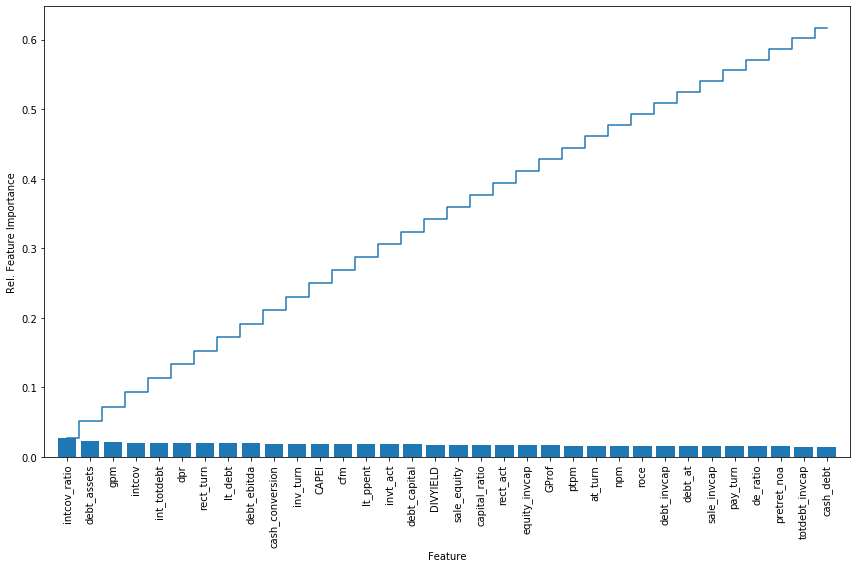

In [16]:
important_features = functions.feature_selection(x = X_train_imputed, y = y_train.values.ravel(), thres=0.015)

In [17]:
#Subset important features matrix for ML algorithms
X_train_imputed = X_train_imputed.loc[:,important_features]
X_test_imputed = X_test_imputed.loc[:, important_features]
X_train_imputed.head(5)

,intcov_ratio,debt_assets,gpm,intcov,int_totdebt,dpr,rect_turn,lt_debt,debt_ebitda,cash_conversion,...,npm,roce,debt_invcap,debt_at,sale_invcap,pay_turn,de_ratio,pretret_noa,totdebt_invcap,cash_debt
6595,8.406000,0.664,0.423,6.1290,0.060000,0.334,4.891,0.309,1.565,73.015000,...,0.070,0.202,0.379,0.207,1.665,4.585000,2.060,0.271000,0.382,0.168
26131,21.132000,0.343,0.803,12.5530,0.040000,0.175,5.000,0.523,0.941,444.210000,...,0.166,0.184,0.215,0.180,0.594,6.532000,0.523,0.341000,0.215,0.294
8093,2.969000,0.728,0.311,2.8250,0.048000,0.476,6.879,0.471,4.441,45.397000,...,0.121,0.085,0.557,0.393,0.463,9.363000,2.674,0.081000,0.640,0.099
23847,-13.028141,0.601,0.899,-3.2231,-0.056181,0.000,6.584,0.367,6.543,69.811797,...,-0.112,0.008,0.356,0.221,0.804,15.649146,1.507,0.017000,0.356,0.263
25714,5.341000,0.923,0.101,2.8370,0.042000,0.547,0.729,0.034,4.584,547.029709,...,0.035,0.072,0.290,0.038,0.773,4.577397,12.111,14.884569,0.348,0.022


In [18]:
X_train_imputed.to_csv('X_train.csv')
X_test_imputed.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

#### For lagging ratings
Same approach as before. We select all the variables which explain more than 1.5%.

 1) intcov_ratio 0.0302
 2) gpm     0.0224
 3) intcov  0.0213
 4) cfm     0.0209
 5) rect_turn 0.0206
 6) debt_ebitda 0.0201
 7) debt_assets 0.0200
 8) int_totdebt 0.0200
 9) inv_turn 0.0196
10) CAPEI   0.0195
11) lt_ppent 0.0192
12) cash_conversion 0.0191
13) dpr     0.0189
14) lt_debt 0.0188
15) equity_invcap 0.0182
16) DIVYIELD 0.0182
17) invt_act 0.0177
18) rect_act 0.0171
19) ptpm    0.0170
20) debt_at 0.0167
21) capital_ratio 0.0166
22) de_ratio 0.0164
23) GProf   0.0162
24) pretret_noa 0.0162
25) debt_invcap 0.0161
26) sale_invcap 0.0160
27) opmbd   0.0160
28) pay_turn 0.0160
29) npm     0.0158
30) pretret_earnat 0.0158
31) at_turn 0.0158
32) sale_equity 0.0158
33) debt_capital 0.0157
34) ps      0.0153
35) int_debt 0.0152
36) totdebt_invcap 0.0151


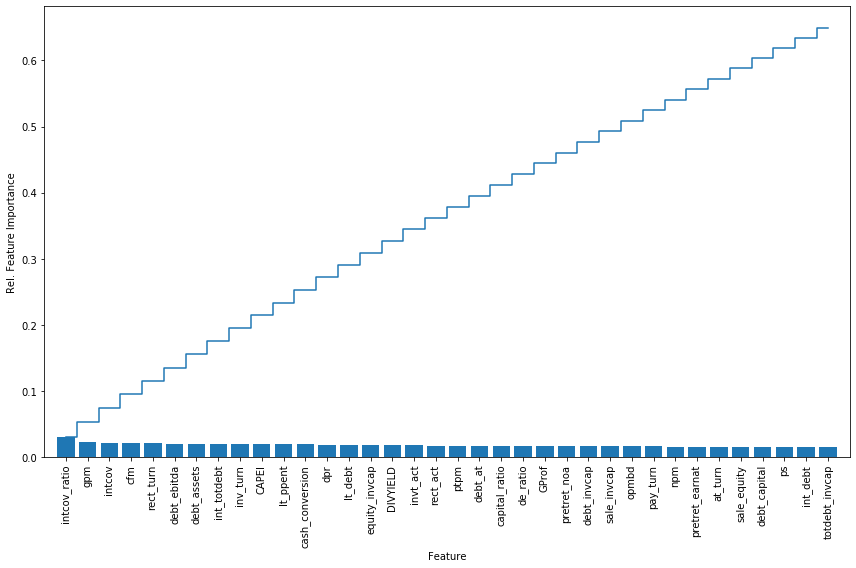

In [19]:
important_features = functions.feature_selection(x = X_train_imputed_lag, y = y_train_lag.values.ravel(), thres=0.015)

In [20]:
#Subset important features matrix for ML algorithms
X_train_imputed_lag = X_train_imputed_lag.loc[:,important_features]
X_test_imputed_lag = X_test_imputed_lag.loc[:, important_features]
X_train_imputed_lag.head(5)

,intcov_ratio,gpm,intcov,cfm,rect_turn,debt_ebitda,debt_assets,int_totdebt,inv_turn,CAPEI,...,opmbd,pay_turn,npm,pretret_earnat,at_turn,sale_equity,debt_capital,ps,int_debt,totdebt_invcap
6595,8.406000,0.423,6.1290,0.113,4.891,1.565,0.664,0.060000,4.554000,36.030,...,0.147,4.585000,0.070,0.164000,0.901,2.794,0.500000,1.884,0.060000,0.382
26131,21.132000,0.803,12.5530,0.245,5.000,0.941,0.343,0.040000,0.844000,24.356,...,0.385,6.532000,0.166,0.283000,0.497,0.757,0.230000,3.769,0.040000,0.215
8093,2.969000,0.311,2.8250,0.254,6.879,4.441,0.728,0.048000,11.322000,14.467,...,0.311,9.363000,0.121,0.068000,0.285,1.046,0.604000,1.501,0.055000,0.640
23847,-13.028141,0.899,-3.2231,-0.054,6.584,6.543,0.601,-0.056181,127.260359,68.029,...,0.068,15.649146,-0.112,0.009000,0.498,1.248,0.375000,4.607,-0.161348,0.356
25714,5.341000,0.101,2.8370,0.028,0.729,4.584,0.923,0.042000,67.877000,20.875,...,0.101,4.577397,0.035,2.539513,0.084,1.097,0.579294,0.757,0.050000,0.348


In [21]:
X_train_imputed_lag.to_csv('X_train_lag.csv')
X_test_imputed_lag.to_csv('X_test_lag.csv')
y_train_lag.to_csv('y_train_lag.csv')
y_test_lag.to_csv('y_test_lag.csv')

# Machine Learning Algorithms
## Ordinary Ratings

### Logistic Regression

In [22]:
## Logistic Regression

X_train = pd.read_csv("X_train.csv")
X_train = X_train.iloc[:, 1:]
X_test = pd.read_csv("X_test.csv")
X_test = X_test.iloc[:, 1:]
Y_train = pd.read_csv("y_train.csv")
Y_test = pd.read_csv("y_test.csv")
Y_train = Y_train['Rating as Factor'].astype('category') #factorize trainset
Y_test = Y_test['Rating as Factor'].astype('category')   #factorize testset

In the grid of logreg__C:[6,6.5,7,7.5,8] and logreg__l1_ratio:[0,0.05,0.1,0.15,0.2,1] the best parameters were: {'logreg__C': 7, 'logreg__l1_ratio': 0, 'logreg__penalty': 'elasticnet'}

A ratio of 0 means that we are using the l2 penalty function (ridge regression regularization and not lasso)

In [23]:
import datetime


param_grid = {'logreg__penalty': ['elasticnet'], #elastic nets combines l1&l2
              'logreg__C':[7],
              'logreg__l1_ratio':[0]} #if 0, or 1 then l2 or l1 would be best. If between then the combination of both

print(datetime.datetime.now())
grid = functions.LogReg(X_train,Y_train,param_grid)
print('Best CV accuracy: {:.4f}'.format(grid.best_score_)) #best parameters are C=7 & ratio=0 -> l2 penalty function
print('Test score:       {:.4f}'.format(grid.score(X_test, Y_test)))
print('Best parameters: {}'.format(grid.best_params_)) #31%
print(datetime.datetime.now()) #10 minutes

2020-04-20 11:05:26.621085
Best CV accuracy: 0.2998
Test score:       0.3094
Best parameters: {'logreg__C': 7, 'logreg__l1_ratio': 0, 'logreg__penalty': 'elasticnet'}
2020-04-20 11:05:43.065480


D:\Programme\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [24]:
# Predict classes
y_pred1 = grid.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred1,
                      'True': Y_test})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))

Predicted   0    1   2   3    4    5   6    7    8   11  12  13  14  15  16
True                                                                       
0          232   31  12   0  235   11   0   70  134   0   0   0   2   4   0
1           55  110  29   0   52   19   2   19  101   0   0   0   0   2   0
2           81   11  27   0   25    2   2    6   42   0   0   0   0   1   1
3           14   16  14  13    0    0   1    0    1   0   0   0   0   0   0
4           96   43   2   0  647   52   2   32  189   0   1  10   5  12   0
5           70   29   7   1  274  107   9   17   95   0   0  22   7   4   0
6           10   13   9   6   21    0  20    6   13   0   0   0   0   0   0
7           95   37   5   0  286   13   0  188  150   0   0   0   1   1   0
8           86   47   1   1  380   48   1   60  289   0   0  13   5   5   0
9           25    0   0   0    2    0   0   11    2   0   0   0   0   0   0
10           0    0   0   0    3    0   0    0    0   4   0   3   0   0   0
11          

### Support Vector Machines

##### Polynomial Kernel function: 
The gridsearch over {'svm_poly__C': [900,1000,1100], 'svm_poly__degree': [3,4,5], 'svm_poly__gamma': [0,0.05,0.1], 'svm_poly__coef0':[0.6]} 
resulted in {'svm_poly__C': 1000, 'svm_poly__coef0': 0.6, 'svm_poly__degree': 4, 'svm_poly__gamma': 0.05} being the best parameters. As the values are not at the gridsearch boundary we found a minima and can therefore stop the gridsearch. 

(Larger gridsearch beforehand yielded 0.6 to be the best coef0. As it does not greatly change the cv accuracy(<1%) we didn't include it in this grid search to lower the computing time.)

##### Radial Basis Kernel Function(rbf):
The gridsearch over {'svm_rbf__C': [100,150,200], 'svm_rbf__gamma': [0.25,0.3,0.35]} (and larger gridsearches beforehand) resulted in {'svm_rbf__C': 150, 'svm_rbf__gamma': 0.3} being the best parameters.

##### Radial Basis Kernel Function(rbf) with Balanced class weights:
The gridsearch over {'svm_rbf__C': [100,200,300], 'svm_rbf__gamma': [0.25,0.3,0.35]}  resulted in {'svm_rbf__C': 200, 'svm_rbf__gamma': 0.3} being the best parameters.

(According to "https://stackoverflow.com/questions/21390570/scikit-learn-svc-coef0-parameter-range" the Sigmoid function does not fulfill the definition of a kernel as it is not positive semidefinite. Therefore we will not use it with Support Vector Machines.)

In [25]:
#######Polynomial Kernel Function#######
param_grid = {'svm_poly__C': [1000], 
              'svm_poly__degree': [4],
              'svm_poly__gamma': [0.05],
              'svm_poly__coef0':[0.6]}
    
print(datetime.datetime.now()) #computation time
poly = functions.SVM_poly(X_train,Y_train, param_grid)
print('Best CV accuracy: {:.4f}'.format(poly.best_score_))
print('Test score:       {:.4f}'.format(poly.score(X_test, Y_test)))
print('Best parameters: {}'.format(poly.best_params_))
print(datetime.datetime.now()) 

# Predict classes
y_pred2 = poly.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred2,
                      'True': Y_test})
print('Polynomial Kernel Function yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 


#######Radial Basis Kernel Function(rbf)#######
param_grid = {'svm_rbf__C': [150], 
              'svm_rbf__gamma': [0.3]} 
print(datetime.datetime.now()) #computation time
rbf = functions.SVM_rbf(X_train,Y_train,param_grid)
print('Best CV accuracy: {:.4f}'.format(rbf.best_score_))
print('Test score:       {:.4f}'.format(rbf.score(X_test, Y_test)))
print('Best parameters: {}'.format(rbf.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred3 = rbf.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred3,
                      'True': Y_test})
print('Radial Basis Function Kernel yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))


#######Radial Basis Kernel Function(rbf) with Balanced class weights#######
param_grid = {'svm_rbf__C': [200], 
              'svm_rbf__gamma': [0.3]} 
print(datetime.datetime.now()) #computation time
rbf_bal = functions.SVM_rbf_bal(X_train,Y_train,param_grid)
print('Best CV accuracy: {:.4f}'.format(rbf_bal.best_score_))
print('Test score:       {:.4f}'.format(rbf_bal.score(X_test, Y_test)))
print('Best parameters: {}'.format(rbf_bal.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred4 = rbf_bal.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred4,
                      'True': Y_test})
print('Radial Basis Function Kernel with Balanced class weights yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))


2020-04-20 11:05:43.122453


D:\Programme\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best CV accuracy: 0.9474
Test score:       0.9595
Best parameters: {'svm_poly__C': 1000, 'svm_poly__coef0': 0.6, 'svm_poly__degree': 4, 'svm_poly__gamma': 0.05}
2020-04-20 11:06:30.277498
Polynomial Kernel Function yields the following confusion matrix:
Predicted   0    1    2   3     4    5   6    7    8   9   10  11  12   13  \
True                                                                         
0          717    6    0   0     1    0   0    5    1   0   0   0   1    0   
1            2  377    8   0     0    0   1    1    0   0   0   0   0    0   
2            2    3  193   0     0    0   0    0    0   0   0   0   0    0   
3            0    0    0  59     0    0   0    0    0   0   0   0   0    0   
4            2    1    0   0  1042   11   1    1   26   0   0   0   0    1   
5            0    3    0   0    18  609   0    1    7   0   0   0   0    2   
6            0    0    3   0     0    0  95    0    0   0   0   0   0    0   
7            9    0    0   0     5    1   0 

Looking at the confusion matrix of non-balanced rbf we see that the smaller classes don't get more wrong classification. Therefore balancing the weights should not influence the outcome greatly which it doesn't


In [26]:
#Define arrays of values to be tested for paramgrid inside GridSearchCV function

#number of trees in the forest
n_estimators = np.array([70])

# Max depth
maxDepth = np.array([25])

# Minimum number of samples required to split any internal node 
minSamplesNode = np.array([2])

# The minimum number of samples required to be at a leaf/terminal node
minSamplesLeaf = np.array([1])

In [27]:
#Run RandomForest Classifier
import datetime
print(datetime.datetime.now())
forest = functions.random_forest(X_train,Y_train, n_estimators, maxDepth, minSamplesNode, minSamplesLeaf)
print('Best CV accuracy: {:.4f}'.format(forest.best_score_))
print('Test score:       {:.4f}'.format(forest.score(X_test,Y_test)))
print('Best parameters: {}'.format(forest.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred5 = forest.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred5,
                      'True': Y_test})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 

2020-04-20 11:09:02.712540
Best CV accuracy: 0.9720
Test score:       0.9755
Best parameters: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
2020-04-20 11:09:13.533830
Predicted   0    1    2   3     4    5   6    7    8   9   10  11  12   13  \
True                                                                         
0          723    5    0   0     0    0   0    3    0   0   0   0   0    0   
1            2  381    3   0     0    0   1    1    1   0   0   0   0    0   
2            0    3  195   0     0    0   0    0    0   0   0   0   0    0   
3            0    0    0  59     0    0   0    0    0   0   0   0   0    0   
4            4    1    0   0  1067    8   0    0    8   0   0   0   0    0   
5            0    0    0   0    14  622   0    0    4   0   0   0   0    0   
6            0    0    0   0     0    0  98    0    0   0   0   0   0    0   
7            6    0    0   0     2    1   0  751   16   0   0   0   0    0   
8            1

The gridsearch was performed several times as the best parameters have been found at the boundaries. The following parameter ranges were tested {"n_estimators: [10,...,100], "max_depth": [1,...,55], "min_samples_split": [2,...,75], "min_samples_leaf": [1,...,50]} and resulted in {"n_estimators: [70], "max_depth": [25], "min_samples_split": [2], "min_samples_leaf": [1]} being the best parameters for the ordinary ratings.As pipelining a grid search doesn't work with the keras wrapper for sklearn we first have to manually standardize the data

### MLP Classifier (Neural Network)

In [28]:
#Define arrays of values to be tested for paramgrid inside GridSearchCV function

#The ith element represents the number of neurons in the ith hidden layer.
hidden_lay = np.array([400])

# Max number of iterations
max_Iter = np.array([575])

In [29]:
#Run MLP Classifier
import datetime
print(datetime.datetime.now())
mlp = functions.neural(X_train,Y_train, hidden_lay, max_Iter)
print('Best CV accuracy: {:.4f}'.format(mlp.best_score_))
print('Test score:       {:.4f}'.format(mlp.score(X_test,Y_test)))
print('Best parameters: {}'.format(mlp.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred6 = mlp.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred6,
                      'True': Y_test})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 

2020-04-20 11:09:13.649854
Best CV accuracy: 0.9382
Test score:       0.9498
Best parameters: {'neural__hidden_layer_sizes': 400, 'neural__max_iter': 575}
2020-04-20 11:13:25.326265
Predicted   0    1    2   3     4    5   6    7    8   9   10  11  12   13  \
True                                                                         
0          706    6    0   0     3    0   0   14    1   0   0   0   0    1   
1            9  365   10   0     0    2   1    2    0   0   0   0   0    0   
2            0    3  195   0     0    0   0    0    0   0   0   0   0    0   
3            0    0    0  59     0    0   0    0    0   0   0   0   0    0   
4            2    1    0   0  1049   16   0    5   14   0   0   0   0    0   
5            0    0    0   0    31  591   0    0    7   0   0   0   0    0   
6            0    0    0   0     0    0  98    0    0   0   0   0   0    0   
7           16    0    0   0     5    1   0  736   17   0   0   0   0    0   
8            2    0    0   0    26    

Performing the gridsearch function on the parameters {"neural__hidden_layer_sizes": [50,...,480], "neural__max_iter": [150,...,635]} identified {"neural__hidden_layer_sizes": [400], "neural__max_iter": [575]} as the best ones. We have also tested the different solvers and learning rates the functions offers. "lbfgs" has proven to be the best solver, while the default setting "constant" for the learning rate yielded the best results.

### Neural Network

As pipelining a grid search doesn't work with the keras wrapper for sklearn we first have to manually standardize the data

In [30]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train) #standardizing using StandardScaler
X_test_std = scaler.transform(X_test) #standardizing using StandardScaler

The best Grid Search would be to test all hyperparameter configurations simultaneously because of possible interactions of the hyperparameters. 
However this would take an extremely long time due to the many hyperparameters and their possible values.
Therefore we take a sequential approach(1 or 2 hyperparameters at a time) on grid searching the hyperparameters to not have to train the model over multiple days.

##### Steps of grid search for hyperparameters:
After 100 epochs the accuracy doesn't improve much therefore we use epoch = 100 in order to have a well trained neural net which doesn't need too much time to fit.

batch_size = [5,10,20] yields that 5 is the best hyperparameter. It makes sense that a lower batch size results in a better accuracy since it optimizes more often. 
A lower batch size means we more often adjust the weights which takes time. 
The differences between the batch size accuracy is only 1% while the time for computing is significantly lower for higher batch sizes. 
Therefore for finding the other optimal hyperparameters we use a batch size of 20 and might adjust it for the final model fitting with the optimal hyperparameters

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] yielded Nadam to be the best optimizer with Adam on second rank.
Nadam is is Adam with Nesterov Momentum as they both take the same amount of time to train we'll use Nadam because of its better accuracy.

Next up we split our gridsearch into a single layered and a two layered neural network.

##### One layer:
For the neural net with one layer we try to find the best combination of activation function and neurons as they interact heavily: Best combination of each activation function for neurons in grid[150,200,250,300]: 

Accuracy (Standard devation): 0.893909 (0.010722) with: {'activ': 'relu', 'neurons': 300}

Accuracy (Standard devation): 0.937349 (0.001372) with: {'activ': 'tanh', 'neurons': 250}

Accuracy (Standard devation): 0.933268 (0.000530) with: {'activ': 'sigmoid', 'neurons': 250

Accuracy (Standard devation): 0.897989 (0.006316) with: {'activ': 'hard_sigmoid', 'neurons': 300}

Accuracy (Standard devation): 0.767458 (0.032144) with: {'activ': 'softmax', 'neurons': 300}

Accuracy (Standard devation): 0.846942 (0.002463) with: {'activ': 'softplus', 'neurons': 300}

Accuracy (Standard devation): 0.935521 (0.003249) with: {'activ': 'softsign', 'neurons': 250}

Accuracy (Standard devation): 0.315170 (0.006817) with: {'activ': 'linear', 'neurons': 300}

We now test the Top 3 activation functions for 200 epochs with neurons grid[250,300,350,400] in hopes that maybe after 200 epochs one activation function will be clearly better:

Best is the Accuracy 0.947295 (0.000936) with: {'activ': 'sigmoid', 'neurons': 350} (1% better than other activation functions)

Next up we checked the dropoutrate combined with a weight restraint. The resulting best hyperparameters for the dropout rate were 0.0 and for the weight constraint the highest possible value. This means that regularization here is not needed and we shouldn't use dropouts or a weight constraint.
Checking dropoutrate together with weight constraint we get a dropout rate of 0.0 and a high weight constraint as best hyperparameters.
This means regularization here does not help and we don't use dropouts or weight constraints. We now have our final model.

##### Two layers:
For the two layered neural net we test the possible combinations of neurons with different activation functions in each layer .
We only included softsign, relu and sigmoid as the possible activation function such that the fitting of the net doesn't take days. We chose these 3 activation functions because sigmoid&softsign performed very well on the single layered neural net and relu seems to be favoured by a lot of people in the literature.
We didn't include tanh because it seems to work very similar to the sigmoid acivation function. 

Grid Search found this as the best combination: Accuracy: 0.943087 using {'activ1': 'sigmoid', 'activ2': 'sigmoid', 'neurons1': 400, 'neurons2': 150}

Again the grid search found that a dropout rate of 0.0 is the best combination in both layers. We now finished the two layered neural network.

In [31]:
#1Layer Neural Net(According to the Universal Approximation Theorem theoretically a 1 Layer Neural Net can approximate any other Neural Network):
#Final model after Hyperparameter optimization. We get a 96% accuracy for the testset
dropout_rate = [0.0]
optimizer = ['Nadam']
activ = ['sigmoid']
neurons = [350]
epochs=[200]
batch_size=[10]
input_dim = [X_train_std.shape[1]]
print(datetime.datetime.now())
# model fitting

param_grid = dict(dropout_rate=dropout_rate, optimizer=optimizer,activ=activ,neurons=neurons,epochs=epochs,batch_size=batch_size, input_dim=input_dim)
grid = functions.NeuralNet1layer(X_train_std,Y_train,param_grid)
#results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print('Test score:', grid.score(X_test_std,Y_test)) 
y_pred7 = grid.predict(X_test_std)
# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred7,
                      'True': Y_test})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 
print(datetime.datetime.now())

2020-04-20 11:13:25.445377
Best: 0.942747 using {'activ': 'sigmoid', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 200, 'input_dim': 34, 'neurons': 350, 'optimizer': 'Nadam'}
0.942747 (0.002627) with: {'activ': 'sigmoid', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 200, 'input_dim': 34, 'neurons': 350, 'optimizer': 'Nadam'}
Test score: 0.958857536315918
Predicted   0    1    2   3     4    5   6    7    8   9   10  11  12   13  \
True                                                                         
0          700   11    0   0     1    2   0   13    3   0   0   0   0    0   
1            1  374   10   0     1    0   1    2    0   0   0   0   0    0   
2            0    4  194   0     0    0   0    0    0   0   0   0   0    0   
3            0    0    0  59     0    0   0    0    0   0   0   0   0    0   
4            3    1    0   0  1058    9   0    3   10   0   0   0   0    0   
5            0    0    0   0    29  592   0    0    6   0   0   0   0    0   
6           

Train: 0.973, Test: 0.952


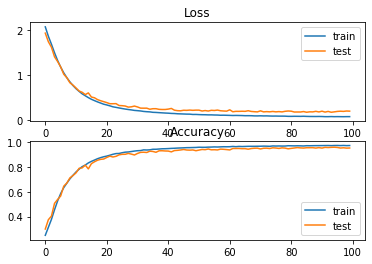

In [32]:
#Training the optimal Neural Network with 1 Layer on the whole Training Data
model = Sequential()
model.add(Dense(350, input_dim = X_train_std.shape[1], activation='sigmoid'))
model.add(Dense(17, activation='softmax'))
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# fit model
history = model.fit(X_train_std, Y_train, validation_data=(X_test_std, Y_test), epochs=100, batch_size=10, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(X_train_std, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test_std, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


In [33]:
#2Layer Neural Net:
activ1 = ['sigmoid']
activ2 = ['sigmoid']
neurons1 = [400]
neurons2 = [150]
dropout_rate1 = [0.0]
dropout_rate2 = [0.0]
input_dim = [X_train_std.shape[1]]
print(datetime.datetime.now())
# model fitting

param_grid = dict(activ1=activ1,activ2=activ2,neurons1=neurons1,neurons2=neurons2,dropout_rate1=dropout_rate1,dropout_rate2=dropout_rate2,input_dim=input_dim)
grid = functions.NeuralNet2layer(X_train_std,Y_train,param_grid)
#results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print('Test score:', grid.score(X_test_std,Y_test)) 
y_pred8 = grid.predict(X_test_std)
# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred8,
                      'True': Y_test})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 
print(datetime.datetime.now())

2020-04-20 11:34:29.354097
Best: 0.944914 using {'activ1': 'sigmoid', 'activ2': 'sigmoid', 'dropout_rate1': 0.0, 'dropout_rate2': 0.0, 'input_dim': 34, 'neurons1': 400, 'neurons2': 150}
0.944914 (0.002446) with: {'activ1': 'sigmoid', 'activ2': 'sigmoid', 'dropout_rate1': 0.0, 'dropout_rate2': 0.0, 'input_dim': 34, 'neurons1': 400, 'neurons2': 150}
Test score: 0.9620877504348755
Predicted   0    1    2   3     4    5   6    7    8   9   10  11  12   13  \
True                                                                         
0          710    9    0   0     1    0   0    9    1   0   0   0   0    1   
1            1  378    8   0     0    0   1    1    0   0   0   0   0    0   
2            0    4  194   0     0    0   0    0    0   0   0   0   0    0   
3            0    0    0  59     0    0   0    0    0   0   0   0   0    0   
4            2    3    0   0  1049    7   0    3   21   0   0   0   0    0   
5            1    0    0   0    22  604   0    1    6   0   0   0   0    

Train: 0.980, Test: 0.956


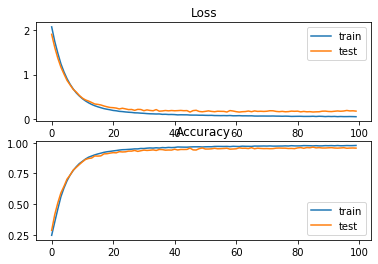

In [34]:
#Training the optimal Neural Network with 2 Layers on the whole Training Data
model = Sequential()
model.add(Dense(400, input_dim=X_train_std.shape[1], activation='sigmoid'))
model.add(Dense(150, activation='sigmoid'))
model.add(Dense(17, activation='softmax'))
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# fit model
history = model.fit(X_train_std, Y_train, validation_data=(X_test_std, Y_test), epochs=100, batch_size=20, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(X_train_std, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test_std, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

As there was no improvement in accuracy of the two layered neural net compared to the single layered one we don't try to fit a three layered model. Also according to the universal approximation theorem a neural network with a single hidden layer containing a finite number of neurons can approximate any continuous functions and therefore a single layered network should be enough to fit our data.

## Lagged Ratings

We are interested to see how our models perform if we used lagged ratings from the next period. 

### Logistic Regression

In [35]:
# Logistic Regression

X_train_lag = pd.read_csv("X_train_lag.csv")
X_train_lag = X_train_lag.iloc[:, 1:]
X_test_lag = pd.read_csv("X_test_lag.csv")
X_test_lag = X_test_lag.iloc[:, 1:]
Y_train_lag = pd.read_csv("y_train_lag.csv")
Y_test_lag = pd.read_csv("y_test_lag.csv")
Y_train_lag = Y_train_lag['Lagging-Rating_1M'].astype('category') #factorize trainset
Y_test_lag = Y_test_lag['Lagging-Rating_1M'].astype('category')   #factorize testset

In [36]:
import datetime
param_grid = {'logreg__penalty': ['elasticnet'], #elastic nets combines l1&l2
              'logreg__C':[7],
              'logreg__l1_ratio':[0]} #if 0, or 1 then l2 or l1 would be best. If between then the combination of both

print(datetime.datetime.now())
grid = functions.LogReg(X_train_lag,Y_train_lag,param_grid)
print('Best CV accuracy: {:.4f}'.format(grid.best_score_))
print('Test score:       {:.4f}'.format(grid.score(X_test_lag, Y_test_lag)))
print('Best parameters: {}'.format(grid.best_params_))
print(datetime.datetime.now())

2020-04-20 11:50:19.004724
Best CV accuracy: 0.3014
Test score:       0.3132
Best parameters: {'logreg__C': 7, 'logreg__l1_ratio': 0, 'logreg__penalty': 'elasticnet'}
2020-04-20 11:50:34.138991


D:\Programme\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [37]:
# Predict classes
y_pred_lag1 = grid.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred_lag1,
                      'True': Y_test_lag})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))

Predicted   0    1    2   3    4    5   6   7   8   9   11  12  13  14
True                                                                  
0          206  302  140   0   74   39   0   0   1   2   0   2   0   0
1           44  637  175   0   87   56   6  13   5  34   0  20   3   1
2           64  383  296   0   67   46   9   5  11  33   0   8   1   1
3            2   10    1  13    0    0   0   3   8   6   0  30   1   0
4           72  240  111   0  257   28   6   1   2   8   0   0   0   0
5           21   56   90   0   64  119  12   0   0  18   0   0   5   0
6            6   14   65   0   72   23  14   0   0   1   0   0   2   0
7           10   93   13   1    9    4   0  35  17  17   1  16   0   0
8           11  151   21   6   31   18   4   5  46  21   0   9   1   0
9           21  293   96   0   64   17   9   2  15  91   0  15   3   2
10           9    0    6   0   21    2   0   0   0   0   0   1   0   0
11           3    9    0   0    0    2   0   0   1   0   5  22   0   0
12    

### Support Vector Machines

In [38]:
#######Polynomial Kernel Function#######
param_grid = {'svm_poly__C': [1000], 
              'svm_poly__degree': [4],
              'svm_poly__gamma': [0.05],
              'svm_poly__coef0':[0.6]}
    
print(datetime.datetime.now()) #computation time
poly = functions.SVM_poly(X_train_lag,Y_train_lag,param_grid)
print('Best CV accuracy: {:.4f}'.format(poly.best_score_))
print('Test score:       {:.4f}'.format(poly.score(X_test_lag, Y_test_lag)))
print('Best parameters: {}'.format(poly.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred_lag2 = poly.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred_lag2,
                      'True': Y_test_lag})
print('Polynomial Kernel Function yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 


#######Radial Basis Kernel Function(rbf)#######
param_grid = {'svm_rbf__C': [150], 
              'svm_rbf__gamma': [0.3]} 
print(datetime.datetime.now()) #computation time
rbf = functions.SVM_rbf(X_train_lag,Y_train_lag,param_grid)
print('Best CV accuracy: {:.4f}'.format(rbf.best_score_))
print('Test score:       {:.4f}'.format(rbf.score(X_test_lag, Y_test_lag)))
print('Best parameters: {}'.format(rbf.best_params_))
print(datetime.datetime.now()) 

# Predict classes
y_pred_lag3 = rbf.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred_lag3,
                      'True': Y_test_lag})
print('Radial Basis Function Kernel yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))


#######Radial Basis Kernel Function(rbf) with Balanced class weights#######
param_grid = {'svm_rbf__C': [200], 
              'svm_rbf__gamma': [0.3]} 
print(datetime.datetime.now()) #computation time
rbf_bal = functions.SVM_rbf_bal(X_train_lag,Y_train_lag,param_grid)
print('Best CV accuracy: {:.4f}'.format(rbf_bal.best_score_))
print('Test score:       {:.4f}'.format(rbf_bal.score(X_test_lag, Y_test_lag)))
print('Best parameters: {}'.format(rbf_bal.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred_lag4 = rbf_bal.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred_lag4,
                      'True': Y_test_lag})
print('Radial Basis Function Kernel with Balanced class weights yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))


2020-04-20 11:50:34.187765


D:\Programme\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best CV accuracy: 0.9457
Test score:       0.9609
Best parameters: {'svm_poly__C': 1000, 'svm_poly__coef0': 0.6, 'svm_poly__degree': 4, 'svm_poly__gamma': 0.05}
2020-04-20 11:51:16.972064
Polynomial Kernel Function yields the following confusion matrix:
Predicted   0     1    2   3    4    5    6    7    8    9   10  11   12  13  \
True                                                                           
0          748     2   10   0    6    0    0    0    0    0   0   0    0   0   
1            5  1032   19   0    4    0    0    1    1   17   0   0    0   2   
2           13    10  897   0    0    0    1    0    0    3   0   0    0   0   
3            0     0    0  71    0    0    0    0    0    0   0   2    1   0   
4           10     4    0   0  708    3    0    0    0    0   0   0    0   0   
5            0     0    0   0    5  376    2    0    0    0   0   0    0   2   
6            0     0    0   0    2    4  189    0    0    0   0   0    0   1   
7            0     0    0 

### Random Forest

In [39]:
#Define arrays of values to be tested for paramgrid inside GridSearchCV function

#number of trees in the forest
n_estimators = np.array([70])

# Max depth
maxDepth = np.array([30])

# Minimum number of samples required to split any internal node 
minSamplesNode = np.array([2])

# The minimum number of samples required to be at a leaf/terminal node
minSamplesLeaf = np.array([1])

In [40]:
#Run RandomForest Classifier
import datetime
print(datetime.datetime.now())
forest = functions.random_forest(X_train_lag,Y_train_lag, n_estimators, maxDepth, minSamplesNode, minSamplesLeaf)
print('Best CV accuracy: {:.4f}'.format(forest.best_score_))
print('Test score:       {:.4f}'.format(forest.score(X_test_lag,Y_test_lag)))
print('Best parameters: {}'.format(forest.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred_lag5 = forest.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred_lag5,
                      'True': Y_test_lag})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 

2020-04-20 11:53:51.505500
Best CV accuracy: 0.9707
Test score:       0.9761
Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
2020-04-20 11:54:04.045018
Predicted   0     1    2   3    4    5    6    7    8    9   10  11   12  13  \
True                                                                           
0          747     1   13   0    4    0    0    0    0    1   0   0    0   0   
1            1  1053   10   0    0    0    0    0    3   14   0   0    0   0   
2           11     8  904   0    0    0    0    0    0    1   0   0    0   0   
3            0     0    0  73    0    0    0    0    0    0   0   1    0   0   
4            3     0    0   0  718    4    0    0    0    0   0   0    0   0   
5            1     0    0   0    5  375    2    0    0    0   0   0    0   2   
6            0     0    0   0    0    4  192    0    0    0   0   0    0   1   
7            0     0    0   0    0    0    0  206    5    3   0   0    2  

The same parameters and ranges have been tested with gridsearch for the lagging ratings. The best parameters are {"n_estimators: [70], "max_depth": [30], "min_samples_split": [2], "min_samples_leaf": [1]}.

### MLP Classifier (Neural Network)

In [41]:
#Define arrays of values to be tested for paramgrid inside GridSearchCV function

#The ith element represents the number of neurons in the ith hidden layer.
hidden_lay = np.array([475])

# Max number of iterations
max_Iter = np.array([625])

In [42]:
#Run MLP Classifier
import datetime
print(datetime.datetime.now())
mlp = functions.neural(X_train_lag,Y_train_lag, hidden_lay, max_Iter)
print('Best CV accuracy: {:.4f}'.format(mlp.best_score_))
print('Test score:       {:.4f}'.format(mlp.score(X_test_lag,Y_test_lag)))
print('Best parameters: {}'.format(mlp.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred_lag6 = mlp.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred_lag6,
                      'True': Y_test_lag})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 

2020-04-20 11:54:04.152971
Best CV accuracy: 0.9396
Test score:       0.9366
Best parameters: {'neural__hidden_layer_sizes': 475, 'neural__max_iter': 625}
2020-04-20 11:57:49.407725
Predicted   0     1    2   3    4    5    6    7    8    9   10  11   12  13  \
True                                                                           
0          712     4   30   0   20    0    0    0    0    0   0   0    0   0   
1            4  1017   32   0    4    0    0    0    1   22   0   0    0   0   
2           20    19  876   0    3    0    0    0    3    3   0   0    0   0   
3            0     0    0  70    0    0    0    0    0    0   0   3    0   0   
4            8     1    4   0  706    6    0    0    0    0   0   0    0   0   
5            0     0    0   0   21  351   11    0    0    0   0   0    0   2   
6            0     0    0   0    0    2  195    0    0    0   0   0    0   0   
7            0     0    0   0    0    0    0  188   21    3   0   0    4   0   
8            0    

The settings for the solver and the learning rate weren't changed for the lagging ratings. The parameters achieving the best score are {"neural__hidden_layer_sizes": [475], "neural__max_iter": [625]}

### Neural Network

In [43]:
scaler = preprocessing.StandardScaler().fit(X_train_lag)
X_train_lag_std = scaler.transform(X_train_lag) #standardizing using StandardScaler
X_test_lag_std = scaler.transform(X_test_lag) #standardizing using StandardScaler

In [44]:
#1Layer Neural Net(According to the Universal Approximation Theorem theoretically a 1 Layer Neural Net can approximate any other Neural Network):
#Final model after Hyperparameter optimization. We get a 96% accuracy for the testset
dropout_rate = [0.0]
optimizer = ['Nadam']
activ = ['sigmoid']
neurons = [350]
epochs=[200]
batch_size=[10]
input_dim = [X_train_lag_std.shape[1]]
print(datetime.datetime.now())
# model fitting

param_grid = dict(dropout_rate=dropout_rate, optimizer=optimizer,activ=activ,neurons=neurons,epochs=epochs,batch_size=batch_size,input_dim=input_dim)
grid = functions.NeuralNet1layer(X_train_lag_std,Y_train_lag,param_grid)
#results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print('Test score:', grid.score(X_test_lag_std,Y_test_lag)) 
y_pred_lag7 = grid.predict(X_test_lag_std)
# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred_lag7,
                      'True': Y_test_lag})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 
print(datetime.datetime.now())

2020-04-20 11:57:49.545640
Best: 0.942922 using {'activ': 'sigmoid', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 200, 'input_dim': 36, 'neurons': 350, 'optimizer': 'Nadam'}
0.942922 (0.003541) with: {'activ': 'sigmoid', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 200, 'input_dim': 36, 'neurons': 350, 'optimizer': 'Nadam'}
Test score: 0.9591661095619202
Predicted   0     1    2   3    4    5    6    7    8    9   10  11   12  13  \
True                                                                           
0          750     2    9   0    5    0    0    0    0    0   0   0    0   0   
1            3  1052   13   0    2    0    2    1    1    7   0   0    0   0   
2           14    10  895   0    0    0    1    0    3    1   0   0    0   0   
3            0     0    0  68    0    0    0    0    0    0   0   1    5   0   
4           18     7    0   0  691    9    0    0    0    0   0   0    0   0   
5            0     1    0   0    4  375    3    0    0    0   0   0    0   

Train: 0.976, Test: 0.957


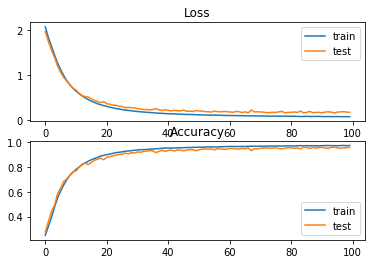

In [45]:
#Training the optimal Neural Network with 1 Layer on the whole Training Data
model = Sequential()
model.add(Dense(350, input_dim=X_train_lag_std.shape[1], activation='sigmoid'))
model.add(Dense(17, activation='softmax'))
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# fit model
history = model.fit(X_train_lag_std, Y_train_lag, validation_data=(X_test_lag_std, Y_test_lag), epochs=100, batch_size=10, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(X_train_lag_std, Y_train_lag, verbose=0)
_, test_acc = model.evaluate(X_test_lag_std, Y_test_lag, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


In [46]:
#2Layer Neural Net:
activ1 = ['sigmoid']
activ2 = ['sigmoid']
neurons1 = [400]
neurons2 = [150]
dropout_rate1 = [0.0]
dropout_rate2 = [0.0]
input_dim = [X_train_lag_std.shape[1]]
print(datetime.datetime.now())
# model fitting

param_grid = dict(activ1=activ1,activ2=activ2,neurons1=neurons1,neurons2=neurons2,dropout_rate1=dropout_rate1,dropout_rate2=dropout_rate2,input_dim=input_dim)
grid = functions.NeuralNet2layer(X_train_lag_std,Y_train_lag,param_grid)
#results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print('Test score:', grid.score(X_test_lag_std,Y_test_lag)) 
y_pred_lag8 = grid.predict(X_test_lag_std)
# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred_lag8,
                      'True': Y_test_lag})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 
print(datetime.datetime.now())

2020-04-20 12:17:37.110737
Best: 0.944947 using {'activ1': 'sigmoid', 'activ2': 'sigmoid', 'dropout_rate1': 0.0, 'dropout_rate2': 0.0, 'input_dim': 36, 'neurons1': 400, 'neurons2': 150}
0.944947 (0.001318) with: {'activ1': 'sigmoid', 'activ2': 'sigmoid', 'dropout_rate1': 0.0, 'dropout_rate2': 0.0, 'input_dim': 36, 'neurons1': 400, 'neurons2': 150}
Test score: 0.959338366985321
Predicted   0     1    2   3    4    5    6    7    8    9   10  11   12  13  \
True                                                                           
0          735     6   19   0    5    0    0    0    0    1   0   0    0   0   
1            1  1051   11   0    0    0    0    0    2   12   0   0    2   2   
2           12    24  883   0    1    0    0    0    0    4   0   0    0   0   
3            0     0    0  72    0    0    0    0    0    0   0   1    0   0   
4           14     4    3   0  699    4    0    0    0    1   0   0    0   0   
5            0     2    0   0    7  371    3    0    0    0 

Train: 0.975, Test: 0.956


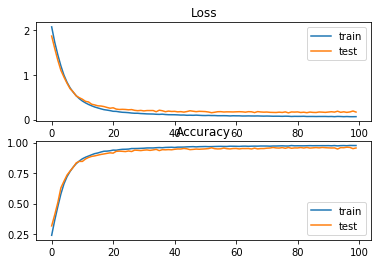

In [47]:
#Training the optimal Neural Network with 2 Layers on the whole Training Data
model = Sequential()
model.add(Dense(400, input_dim=X_train_lag_std.shape[1], activation='sigmoid'))
model.add(Dense(150, activation='sigmoid'))
model.add(Dense(17, activation='softmax'))
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# fit model
history = model.fit(X_train_lag_std, Y_train_lag, validation_data=(X_test_lag_std, Y_test_lag), epochs=100, batch_size=20, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(X_train_lag_std, Y_train_lag, verbose=0)
_, test_acc = model.evaluate(X_test_lag_std, Y_test_lag, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

### Performance Metrics

We now look at the performance metrics of the baseline model and the top 3 for lagged & non-lagged ratings
##### Non-lagged Ratings:

In [48]:
#To find the order of classes for the non lagged ratings(for the lagged ratings we use this command already when creating the lagged values before we factorize them):
print(np.bincount(Y_test))
print(pd.factorize(df["splticrm"])[1]) 

[ 731  389  198   59 1091  642   98  776  936   40   10   29   76  214
  330  219   44]
Index(['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+',
       'CCC+', 'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
      dtype='object')


Logistic Regression:
              precision    recall  f1-score   support

           0      0.289     0.317     0.302       731
           1      0.303     0.283     0.293       389
           2      0.237     0.136     0.173       198
           3      0.619     0.220     0.325        59
           4      0.292     0.593     0.392      1091
           5      0.323     0.167     0.220       642
           6      0.476     0.204     0.286        98
           7      0.432     0.242     0.310       776
           8      0.264     0.309     0.285       936
           9      0.000     0.000     0.000        40
          10      0.000     0.000     0.000        10
          11      0.375     0.103     0.162        29
          12      0.609     0.184     0.283        76
          13      0.312     0.313     0.312       214
          14      0.560     0.155     0.242       330
          15      0.412     0.215     0.282       219
          16      0.357     0.114     0.172        44

    a

D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


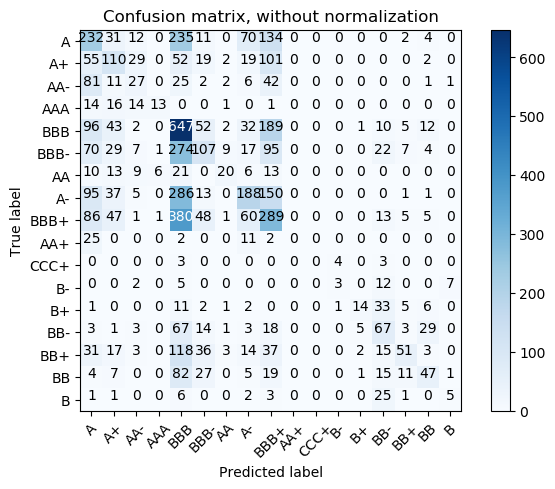

In [49]:
plt.style.use('default')
print('Logistic Regression:')
print(metrics.classification_report(Y_test, y_pred1, digits=3))
# Compute confusion matrix
confm = confusion_matrix(y_test, y_pred1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(confm, classes=['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+', 'CCC+', 
                                     'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
                      title='Confusion matrix, without normalization');


Random Forest:
              precision    recall  f1-score   support

           0      0.982     0.989     0.986       731
           1      0.977     0.979     0.978       389
           2      0.985     0.985     0.985       198
           3      1.000     1.000     1.000        59
           4      0.978     0.978     0.978      1091
           5      0.970     0.969     0.970       642
           6      0.990     1.000     0.995        98
           7      0.980     0.968     0.974       776
           8      0.969     0.979     0.974       936
           9      1.000     1.000     1.000        40
          10      1.000     1.000     1.000        10
          11      0.964     0.931     0.947        29
          12      0.892     0.974     0.931        76
          13      0.976     0.967     0.972       214
          14      0.970     0.964     0.967       330
          15      0.972     0.954     0.963       219
          16      1.000     0.932     0.965        44

    accurac

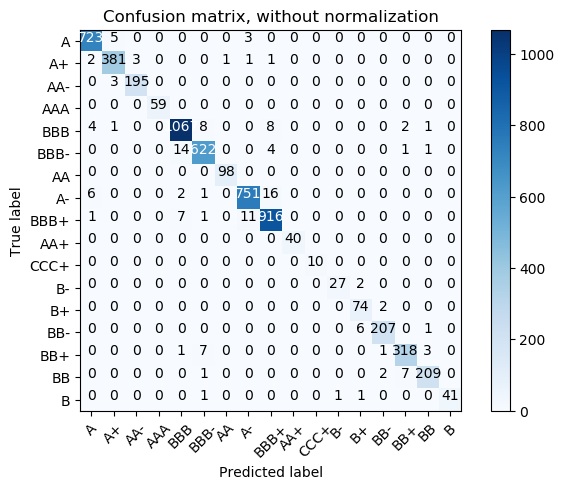

In [50]:
plt.style.use('default')
print('Random Forest:')
print(metrics.classification_report(Y_test, y_pred5, digits=3))
# Compute confusion matrix
confm = confusion_matrix(y_test, y_pred5)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(confm, classes=['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+', 'CCC+', 
                                     'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
                      title='Confusion matrix, without normalization');


Support Vector Machine with radial basis kernel function:
              precision    recall  f1-score   support

           0      0.986     0.977     0.981       731
           1      0.964     0.977     0.971       389
           2      0.956     0.980     0.968       198
           3      1.000     1.000     1.000        59
           4      0.971     0.968     0.969      1091
           5      0.966     0.970     0.968       642
           6      0.990     0.969     0.979        98
           7      0.973     0.973     0.973       776
           8      0.967     0.975     0.971       936
           9      1.000     1.000     1.000        40
          10      1.000     1.000     1.000        10
          11      0.964     0.931     0.947        29
          12      0.924     0.961     0.942        76
          13      0.967     0.958     0.962       214
          14      0.957     0.955     0.956       330
          15      0.958     0.936     0.947       219
          16      0.976

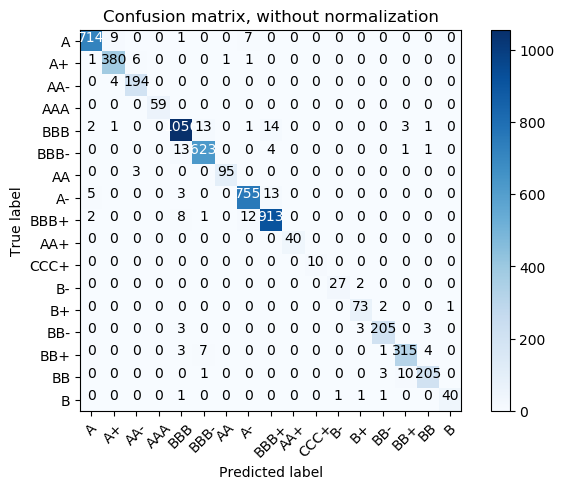

In [51]:
plt.style.use('default')
print('Support Vector Machine with radial basis kernel function:')
print(metrics.classification_report(Y_test, y_pred3, digits=3))
# Compute confusion matrix
confm = confusion_matrix(y_test, y_pred3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(confm, classes=['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+', 'CCC+', 
                                     'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
                      title='Confusion matrix, without normalization');


Two layered Neural Network:
              precision    recall  f1-score   support

           0      0.982     0.971     0.977       731
           1      0.959     0.972     0.966       389
           2      0.960     0.980     0.970       198
           3      0.983     1.000     0.992        59
           4      0.965     0.962     0.963      1091
           5      0.979     0.941     0.959       642
           6      0.990     0.980     0.985        98
           7      0.959     0.965     0.962       776
           8      0.951     0.969     0.960       936
           9      1.000     1.000     1.000        40
          10      0.909     1.000     0.952        10
          11      0.963     0.897     0.929        29
          12      0.925     0.974     0.949        76
          13      0.967     0.944     0.955       214
          14      0.943     0.952     0.947       330
          15      0.932     0.936     0.934       219
          16      0.894     0.955     0.923        44

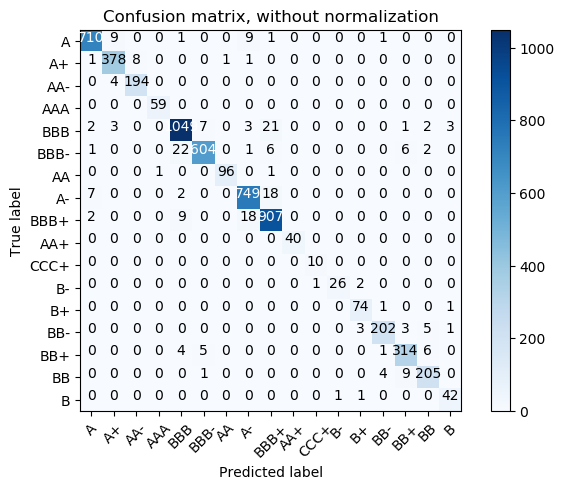

In [52]:
plt.style.use('default')
print('Two layered Neural Network:')
print(metrics.classification_report(Y_test, y_pred8, digits=3))
# Compute confusion matrix
confm = confusion_matrix(y_test, y_pred8)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(confm, classes=['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+', 'CCC+', 
                                     'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
                      title='Confusion matrix, without normalization');


##### Lagged Ratings:

Logistic Regression:
              precision    recall  f1-score   support

           0      0.420     0.269     0.328       766
           1      0.278     0.589     0.378      1081
           2      0.284     0.320     0.301       924
           3      0.464     0.176     0.255        74
           4      0.329     0.354     0.342       725
           5      0.300     0.309     0.304       385
           6      0.194     0.071     0.104       197
           7      0.449     0.162     0.238       216
           8      0.414     0.142     0.211       324
           9      0.386     0.145     0.211       628
          10      0.000     0.000     0.000        39
          11      0.385     0.119     0.182        42
          12      0.364     0.383     0.374       214
          13      0.273     0.064     0.103        94
          14      0.550     0.190     0.282        58
          15      0.000     0.000     0.000         8
          16      0.000     0.000     0.000        29

    a

D:\Programme\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


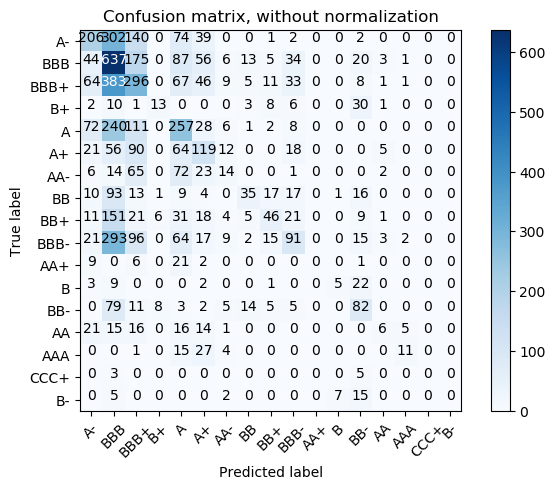

In [53]:
plt.style.use('default')
print('Logistic Regression:')
print(metrics.classification_report(Y_test_lag, y_pred_lag1, digits=3))
# Compute confusion matrix
confm = confusion_matrix(y_test_lag, y_pred_lag1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(confm, classes=['A-', 'BBB', 'BBB+', 'B+', 'A', 'A+', 'AA-', 'BB', 'BB+', 'BBB-', 'AA+', 
                                     'B', 'BB-', 'AA', 'AAA', 'CCC+', 'B-'],
                      title='Confusion matrix, without normalization');


Random Forest:
              precision    recall  f1-score   support

           0      0.979     0.975     0.977       766
           1      0.985     0.974     0.980      1081
           2      0.969     0.978     0.974       924
           3      0.936     0.986     0.961        74
           4      0.988     0.990     0.989       725
           5      0.979     0.974     0.977       385
           6      0.975     0.975     0.975       197
           7      0.967     0.954     0.960       216
           8      0.966     0.978     0.972       324
           9      0.964     0.971     0.967       628
          10      1.000     1.000     1.000        39
          11      0.975     0.929     0.951        42
          12      0.981     0.972     0.977       214
          13      0.968     0.968     0.968        94
          14      1.000     1.000     1.000        58
          15      0.800     1.000     0.889         8
          16      1.000     0.931     0.964        29

    accurac

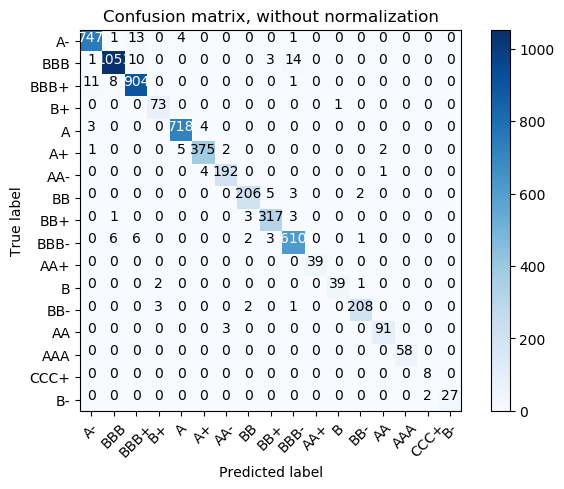

In [54]:
plt.style.use('default')
print('Random Forest:')
print(metrics.classification_report(Y_test_lag, y_pred_lag5, digits=3))
# Compute confusion matrix
confm = confusion_matrix(y_test_lag, y_pred_lag5)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(confm, classes=['A-', 'BBB', 'BBB+', 'B+', 'A', 'A+', 'AA-', 'BB', 'BB+', 'BBB-', 'AA+', 
                                     'B', 'BB-', 'AA', 'AAA', 'CCC+', 'B-'],
                      title='Confusion matrix, without normalization');


Support Vectore Machine with radial basis kernel function and balanced class weights:
              precision    recall  f1-score   support

           0      0.977     0.983     0.980       766
           1      0.979     0.967     0.973      1081
           2      0.967     0.982     0.974       924
           3      0.923     0.973     0.947        74
           4      0.985     0.982     0.983       725
           5      0.977     0.977     0.977       385
           6      0.970     0.975     0.972       197
           7      0.950     0.963     0.956       216
           8      0.960     0.975     0.968       324
           9      0.971     0.960     0.966       628
          10      1.000     1.000     1.000        39
          11      0.927     0.905     0.916        42
          12      0.981     0.944     0.962       214
          13      0.958     0.968     0.963        94
          14      1.000     1.000     1.000        58
          15      0.800     1.000     0.889      

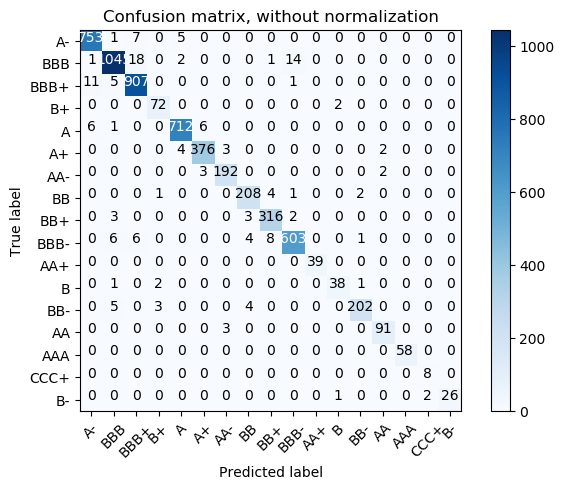

In [55]:
plt.style.use('default')
print('Support Vectore Machine with radial basis kernel function and balanced class weights:')
print(metrics.classification_report(Y_test_lag, y_pred_lag4, digits=3))
# Compute confusion matrix
confm = confusion_matrix(y_test_lag, y_pred_lag4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(confm, classes=['A-', 'BBB', 'BBB+', 'B+', 'A', 'A+', 'AA-', 'BB', 'BB+', 'BBB-', 'AA+', 
                                     'B', 'BB-', 'AA', 'AAA', 'CCC+', 'B-'],
                      title='Confusion matrix, without normalization');


Two layered neural network:
              precision    recall  f1-score   support

           0      0.965     0.960     0.962       766
           1      0.942     0.972     0.957      1081
           2      0.957     0.956     0.956       924
           3      0.923     0.973     0.947        74
           4      0.980     0.964     0.972       725
           5      0.976     0.964     0.970       385
           6      0.970     0.970     0.970       197
           7      0.940     0.944     0.942       216
           8      0.948     0.963     0.956       324
           9      0.963     0.943     0.953       628
          10      1.000     1.000     1.000        39
          11      0.976     0.952     0.964        42
          12      0.965     0.911     0.938       214
          13      0.948     0.968     0.958        94
          14      1.000     1.000     1.000        58
          15      0.800     1.000     0.889         8
          16      0.964     0.931     0.947        29

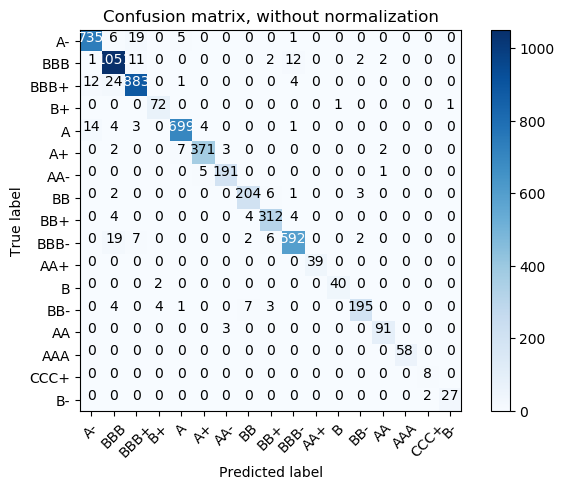

In [56]:
plt.style.use('default')
print('Two layered neural network:')
print(metrics.classification_report(Y_test_lag, y_pred_lag8, digits=3))
# Compute confusion matrix
confm = confusion_matrix(y_test_lag, y_pred_lag8)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
functions.plot_confusion_matrix(confm, classes=['A-', 'BBB', 'BBB+', 'B+', 'A', 'A+', 'AA-', 'BB', 'BB+', 'BBB-', 'AA+', 
                                     'B', 'BB-', 'AA', 'AAA', 'CCC+', 'B-'],
                      title='Confusion matrix, without normalization');


In [57]:
print(datetime.datetime.now()) #Runtime of whole program: 90Minutes

2020-04-20 12:33:23.037018
